# GP para Classificação

Neste tutorial, exploraremos a aplicação de Processos Gaussianos (GPs) para classificar o conhecido dataset de Iris. Este dataset inclui alvos categóricos rotulados como 0, 1 e 2, representando três espécies de flores de Iris, respectivamente.

O dataset de Iris é um clássico no campo de aprendizado de máquina. Consiste em 150 amostras de três espécies de Iris (Iris setosa, Iris versicolor e Iris virginica). Cada amostra possui quatro características: comprimento da sépala, largura da sépala, comprimento da pétala e largura da pétala.

# Erros Comuns na Classificação com GPs

Um erro comum ao usar Processos Gaussianos para classificação é a utilização inadequada da função de verossimilhança marginal. Muitas vezes, por falta de conhecimento específico, alguns praticantes tentam aplicar esta abordagem diretamente para modelar a probabilidade dos dados de classes, o que não é recomendado.

Por que não usar a verossimilhança marginal?
A verossimilhança marginal em GPs é geralmente utilizada para modelar dados contínuos e não é adequada para dados categóricos devido à sua natureza. Utilizar essa abordagem pode levar a interpretações errôneas e a um desempenho subóptimo do modelo.

Abordagem Recomendada: GPs Latentes
A maneira correta de aplicar GPs para classificação de dados categóricos é através de um modelo latente. Os GPs latentes tratam as categorias de forma implícita, modelando uma função latente contínua, que é então transformada em uma probabilidade de classe através de uma função de ligação, como a função softmax para múltiplas classes.

e ser transformada para se adequar ao formato categórico dos dados alvo.

# Configuração
Definição do Priori do GP: Inicialmente, definimos um priori de GP para a função latente. Esse priori descreve nossas crenças prévias sobre a distribuição da função antes de observarmos qualquer dado. Um GP é completamente especificado por sua função média e função de covariância (ou kernel) como visto nas aulas anteriores.

Depois de definir o priori do GP, utilizamos este GP para modelar a função latente. Para dados categóricos, a função latente modelada por este GP não é diretamente observável e não corresponde diretamente às categorias. Em vez disso, ela serve como uma base contínua sobre a qual aplicamos uma transformação posterior para obter probabilidades de classe.

Transformação para o Espaço Categórico: A transformação mais comum é a função softmax, que mapeia as funções latentes contínuas para probabilidades de classe. Cada classe é modelada por uma função latente separada, e a função softmax assegura que as saídas de todas as funções latentes somem a 1, formando assim uma distribuição de probabilidade válida.

$$ \text{softmax}(v_i) = \frac{e^{v_i}}{\sum_j e^{v_j}} $$


# Cálculo das Exponenciais de Cada Logit:
- $v_1 = 2.0$, $e^{2.0} \approx 7.389$
- $v_2 = 1.0,$  $e^{1.0} \approx 2.718 $
- $z_3 = 0.1$, $e^{0.1} \approx 1.105 $

- Soma das Exponenciais:
$ Soma = 7.389 + 2.718 + 1.105 \approx 11.212 $

# Probabilidades:
  - Probabilidade de $v_1 = 2.0$: $ \frac{7.389}{11.212} \approx 0.659 $
  - Probabilidade de $v_2 = 1.0$: $ \frac{2.718}{11.212} \approx 0.242 $
  - Probabilidade de $v_3 = 0.1$: $ \frac{1.105}{11.212} \approx 0.099 $

Logo, $\text{softmax}(2.0,1.0,0.1) = (0.659,0.242,0.099)$

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install ucimlrepo
import ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# metadata
print(iris.metadata)

# variable information
print(iris.variables)


{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'published_in': 'Significance, 2021', 'year': 2021, 'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e', 'doi': '1740-9713.01589'}, 'add

In [3]:
def replace(x):
  if (x == 'Iris-setosa'): return 0
  if (x == 'Iris-versicolor'): return 1
  if (x == 'Iris-virginica'): return 2
Y = [replace(elem[0]) for elem in y.values]
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [4]:
X.values

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [4]:
with pm.Model() as model:
    l = pm.HalfNormal("l0", 1)
    cov = pm.gp.cov.ExpQuad(4, ls=l)
    gp = pm.gp.Marginal(cov_func=cov)

    s = pm.HalfNormal("s0", sigma=1, shape=3)

    l1 = pm.HalfNormal("l1", 1)
    cov1 = pm.gp.cov.ExpQuad(4, ls=l1)
    gp1 = pm.gp.Marginal(cov_func=cov1)

    l2 = pm.HalfNormal("l2", 1)
    cov2 = pm.gp.cov.ExpQuad(4, ls=l2)
    gp2 = pm.gp.Marginal(cov_func=cov2)


    f = gp.marginal_likelihood("f", X=X.values, y=Y, sigma=s[0])
    g = gp1.marginal_likelihood("g", X=X.values, y=Y, sigma=s[1])
    h = gp2.marginal_likelihood("h", X=X.values, y=Y, sigma=s[2])

    fs = pm.math.stack([f, g, h], axis=1)
    j = pm.Deterministic("j", fs)
    p = pm.Deterministic("p", pm.math.softmax(fs,axis=1))

    y_obs = pm.Categorical("y_obs", p=p, observed=Y)


In [20]:
with model:
  trace_approx = pm.fit(20000)
  trace = trace_approx.sample()

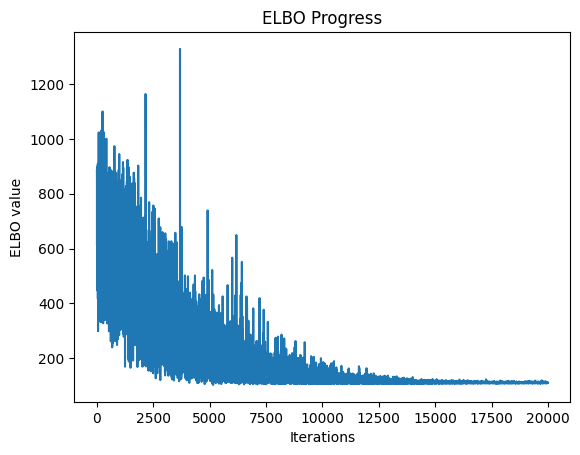

In [21]:
plt.plot(trace_approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [22]:
with model:
  trace_post = pm.sample_posterior_predictive(trace)

In [23]:
trace_post

Inference data with groups:
	> posterior_predictive
	> observed_data

In [56]:
y_preds = trace_post.posterior_predictive["y_obs"].values
y_preds

array([[[2, 0, 2, ..., 1, 2, 1],
        [2, 2, 1, ..., 0, 2, 2],
        [0, 0, 1, ..., 2, 0, 0],
        ...,
        [1, 2, 1, ..., 2, 0, 2],
        [0, 0, 2, ..., 1, 1, 1],
        [0, 0, 2, ..., 2, 1, 2]]])

In [59]:
import numpy as np
from scipy.stats import mode

mode_predictions, _ = mode(y_preds.reshape(-1, y_preds.shape[2]), axis=0)
predictions = mode_predictions.squeeze()

print(predictions)


[1 1 1 1 1 2 0 1 2 1 0 0 1 1 1 0 1 0 1 2 1 1 0 1 1 1 2 2 0 1 1 0 1 2 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 2 0 1 0 2 0 2 1 2 2 2 1 0 0 2 2 2 1 0 2 2 0 2 2 2 0
 2 1 2 0 0 0 2 1 2 2 0 1 2 2 1 2 0 2 1 1 2 2 0 1 2 0 2 0 2 0 0 2 0 0 2 2 1
 2 2 2 2 1 0 2 2 0 1 2 2 0 1 1 0 1 2 2 2 2 0 2 0 0 2 0 0 2 0 1 0 0 0 2 0 2
 1 0]


In [66]:
P = predictions-Y
len(P[P==0])/len(Y)

0.29333333333333333

In [5]:
with pm.Model() as model_l:
    l = pm.HalfNormal("l0", 1)
    cov = pm.gp.cov.ExpQuad(4, ls=l)
    gp = pm.gp.Latent(cov_func=cov)

    s = pm.HalfNormal("s0", sigma=1, shape=3)

    l1 = pm.HalfNormal("l1", 1)
    cov1 = pm.gp.cov.ExpQuad(4, ls=l1)
    gp1 = pm.gp.Latent(cov_func=cov1)

    l2 = pm.HalfNormal("l2", 1)
    cov2 = pm.gp.cov.ExpQuad(4, ls=l2)
    gp2 = pm.gp.Latent(cov_func=cov2)


    f = gp.prior("f", X=X.values)
    g = gp1.prior("g", X=X.values)
    h = gp2.prior("h", X=X.values)

    fs = pm.math.stack([f, g, h], axis=1)
    j = pm.Deterministic("j", fs)
    p = pm.Deterministic("p", pm.math.softmax(fs,axis=1))

    y_obs = pm.Categorical("y_obs", p=p, observed=Y)


In [9]:
with model_l:
  trace_approx_l = pm.fit(20000)
  trace_l = trace_approx_l.sample()

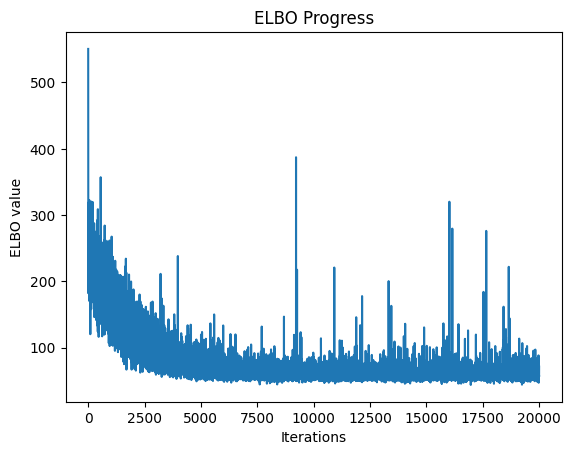

In [10]:
plt.plot(trace_approx_l.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [11]:
with model_l:
  trace_post_l = pm.sample_posterior_predictive(trace_l)

In [12]:
y_preds_l = trace_post_l.posterior_predictive["y_obs"].values
y_preds_l

array([[[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 2, 0, ..., 2, 0, 2]]])

In [14]:
import numpy as np
from scipy.stats import mode

mode_predictions_l, _ = mode(y_preds_l.reshape(-1, y_preds_l.shape[2]), axis=0)
predictions_l = mode_predictions_l.squeeze()

print(predictions_l)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [17]:
P = predictions_l-Y
print(f"Acuracia: {len(P[P==0])/len(Y)}")
print(f"Acertos: {len(P[P==0])}")
print(f"Erros: {len(Y)-len(P[P==0])}")

Acuracia: 0.9733333333333334
Acertos: 146
Erros: 4


In [5]:
with pm.Model() as model_p:
    l = pm.HalfNormal("l0", 1)
    cov = pm.gp.cov.Matern32(4, ls=l)
    gp = pm.gp.Latent(cov_func=cov)

    s = pm.HalfNormal("s0", sigma=1, shape=3)

    l1 = pm.HalfNormal("l1", 1)
    cov1 = pm.gp.cov.Matern32(4, ls=l1)
    gp1 = pm.gp.Latent(cov_func=cov1)

    l2 = pm.HalfNormal("l2", 1)
    cov2 = pm.gp.cov.Matern32(4, ls=l2)
    gp2 = pm.gp.Latent(cov_func=cov2)


    f = gp.prior("f", X=X.values)
    g = gp1.prior("g", X=X.values)
    h = gp2.prior("h", X=X.values)

    fs = pm.math.stack([f, g, h], axis=1)
    j = pm.Deterministic("j", fs)
    p = pm.Deterministic("p", pm.math.softmax(fs,axis=1))

    y_obs = pm.Categorical("y_obs", p=p, observed=Y)


In [6]:
with model_p:
  trace_approx_p = pm.fit(20000)
  trace_p = trace_approx_p.sample()

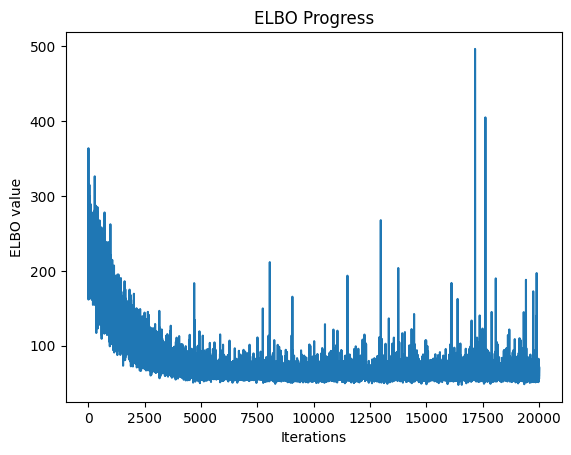

In [8]:
plt.plot(trace_approx_p.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()

In [9]:
with model_p:
  trace_post_p = pm.sample_posterior_predictive(trace_p)

In [10]:
y_preds_p = trace_post_p.posterior_predictive["y_obs"].values
y_preds_p

array([[[0, 0, 0, ..., 1, 2, 2],
        [0, 1, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 1],
        [0, 0, 1, ..., 2, 2, 2]]])

In [12]:
import numpy as np
from scipy.stats import mode

mode_predictions_p, _ = mode(y_preds_p.reshape(-1, y_preds_p.shape[2]), axis=0)
predictions_p = mode_predictions_p.squeeze()

print(predictions_p)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [13]:
P = predictions_p-Y
print(f"Acuracia: {len(P[P==0])/len(Y)}")
print(f"Acertos: {len(P[P==0])}")
print(f"Erros: {len(Y)-len(P[P==0])}")

Acuracia: 0.9733333333333334
Acertos: 146
Erros: 4


In [41]:
diff_indices = predictions_p != Y
diff_indices

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-2.26454173e+00,  5.05703903e-01],
       [-2.08642550e+00, -6.55404729e-01],
       [-2.36795045e+00, -3.18477311e-01],
       [-2.30419716e+00, -5.75367713e-01],
       [-2.38877749e+00,  6.74767397e-01],
       [-2.07053681e+00,  1.51854856e+00],
       [-2.44571134e+00,  7.45626750e-02],
       [-2.23384186e+00,  2.47613932e-01],
       [-2.34195768e+00, -1.09514636e+00],
       [-2.18867576e+00, -4.48629048e-01],
       [-2.16348656e+00,  1.07059558e+00],
       [-2.32737775e+00,  1.58587455e-01],
       [-2.22408272e+00, -7.09118158e-01],
       [-2.63971626e+00, -9.38281982e-01],
       [-2.19229151e+00,  1.88997851e+00],
       [-2.25146521e+00,  2.72237108e+00],
       [-2.20275048e+00,  1.51375028e+00],
       [-2.19017916e+00,  5.14304308e-01],
       [-1.89407429e+00,  1.43111071e+00],
       [-2.33994907e+00,  1.15803343e+00],
       [-1.91455639e+00,  4.30465163e-01],
       [-2.20464540e+00,  9.52457317e-01],
       [-2.77416979e+00,  4.89517027e-01],
       [-1.

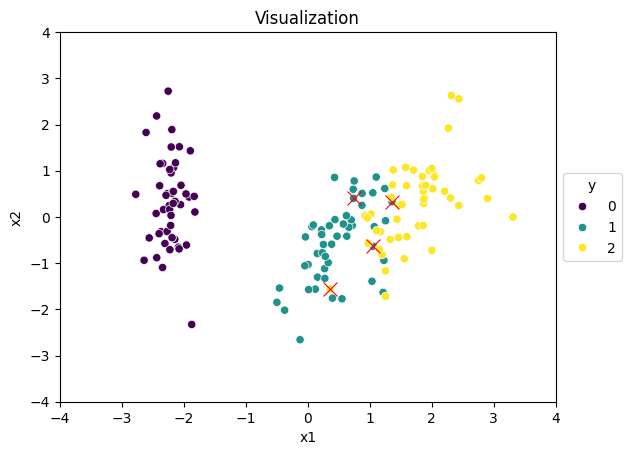

In [42]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=Y,
    ax=ax,
    palette='viridis',
)
sns.scatterplot(x=X_pca[diff_indices, 0], y=X_pca[diff_indices, 1], marker='x', color='red', s=100, ax=ax)

ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Visualization", xlim=(-4, 4), ylim=(-4, 4), xlabel="x1", ylabel="x2");


# Exercícios

1) Use o HSGP visto nas aulas anteriores e aplique ao mesmo modelo ao invés do Latent. Há melhora nos resultados?

2) Use outros kernels e verifique se há melhoras no modelo.

3) Aplicar as prioris GP para fazer uma classificação no dataset da P1. Os resultados foram melhores?